In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt


In [2]:
# GPU or CPU device to use
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [17]:
# convert data to a normalized torch.FloatTensor
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    ])

# choose the training and test datasets
train_data = datasets.MNIST('mnist_data', train=True,
                              download=True, transform=train_transform)
test_data = datasets.MNIST('mnist_data', train=False,
                             download=True, transform=test_transform)

print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: mnist_data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [4]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=512, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, num_workers=1)


tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5])


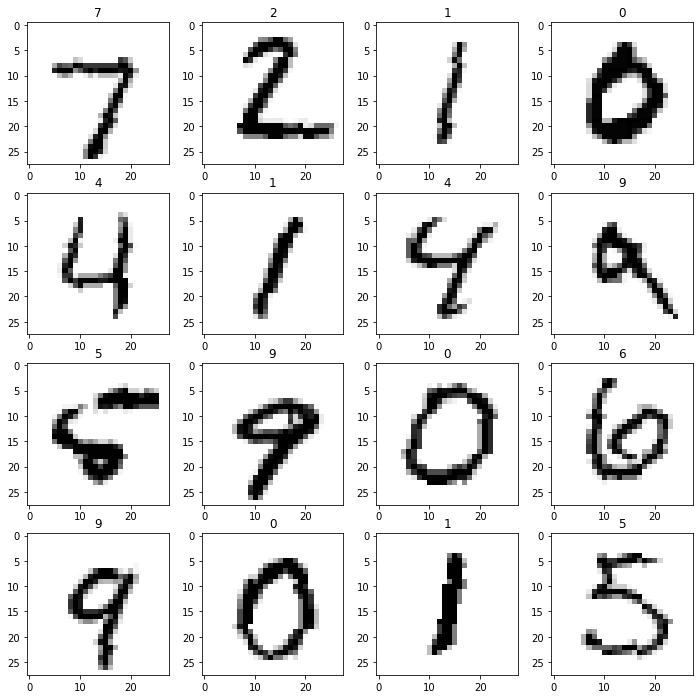

In [5]:
batch = next(iter(test_loader))
data, target = batch
print(target)

_data = data.data.cpu().numpy()
_target = target.data.cpu().numpy()

plt.figure(figsize=[12, 12])
for i in range(16):
    plt.subplot(4, 4, i+1)
    clazz = str(_target[i])
    plt.title(clazz)
    plt.imshow(_data[i][0], cmap='binary')
plt.show()


In [7]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2),
                                   
                                   nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2))
        
        self.linears = nn.Sequential(nn.Linear(in_features=64 * 5 * 5, out_features=512),
                                     nn.ReLU(),
                                     nn.Linear(in_features=512, out_features=10))
        
    def forward(self, x, t):
        '''
        x : [batch, channel=1, width=32, height=32]
        t : [batch]
        '''
        
        # [batch, channel, width, height]
        y = self.convs(x)
        # [batch, feature]
        y = y.view(-1, 64 * 5 * 5)
        # [batch, class]
        y = self.linears(y)
        
        return y


In [8]:
import os
from tensorboardX import SummaryWriter

class Logger(SummaryWriter):
    def __init__(self, logdir):
        super(Logger, self).__init__(logdir)

    def log(self, log_string, value, iteration):
            self.add_scalar(log_string, value, iteration)

save_dir = 'save/CNN_mnist_nodropout'
#!rm -rf $save_dir

logger = Logger(save_dir)

!ls $save_dir


events.out.tfevents.1580593540.scpark-X299-WU8


In [9]:
model = Model().to(DEVICE)
print(model)

optimizer = torch.optim.Adam(model.parameters(), 1e-4)
print(optimizer)

step = 0
path = save_dir + '/' + 'save_' + str(step)
if os.path.exists(path) and True:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    step = checkpoint['step']
    step += 1
    print('checkpoint loaded')
    

Model(
  (convs): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linears): Sequential(
    (0): Linear(in_features=1600, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)


In [10]:
from IPython import display
import matplotlib.pyplot as plt

model.train()

while(True):
    for batch_index, batch in enumerate(train_loader):

        x, t = batch
        x = x.to(DEVICE)
        t = t.to(DEVICE)

        model.zero_grad()
        y = model(x, t)

        loss = nn.CrossEntropyLoss()(y, t)
        loss.backward()
        optimizer.step()

        print(batch_index, loss.item())
        
        if step % 10 == 0:
            logger.log('loss', loss.item(), step)

        if step % 1000 == 0:
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)

            path = save_dir + '/' + 'save_' + str(step)
            torch.save({
                'step': step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, path)
            print('saved', path)
            
            '''
            Test
            '''
            correct = []
            for batch_index, batch in enumerate(test_loader):

                    x, t = batch
                    x = x.to(DEVICE)
                    t = t.to(DEVICE)

                    y = model(x, t)
                    _y = y.data.cpu().numpy()
                    _y = np.argmax(_y, axis=1)
                    _t = t.data.cpu().numpy()

                    correct.append((_y == _t))

            correct = np.concatenate(correct)
            precision = np.sum(correct) / len(correct)

            logger.log('test precision', precision, step)

        if step % 100 == 0:
            display.clear_output()
            _y = y.data.cpu().numpy()
            _t = t.data.cpu().numpy()
            print(_t[0])
            plt.plot(_y[0])
            plt.show()
         
        step += 1

9


KeyboardInterrupt: 

In [28]:
correct = []
for batch_index, batch in enumerate(test_loader):

        x, t = batch
        x = x.to(DEVICE)
        t = t.to(DEVICE)
        
        y_list = []
        for _ in range(100):
            y = model(x, t)
            y = F.softmax(y)
            y_list.append(y)
        ys = torch.stack(y_list)
        
        _ys = ys.data.cpu().numpy()
        _y = np.mean(_ys, axis=0)
        _y = np.argmax(_y, axis=1)
        _t = t.data.cpu().numpy()

        correct.append((_y == _t))
        break

correct = np.concatenate(correct)
precision = np.sum(correct) / len(correct)
print(precision)


1.0


/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


In [44]:
mean = np.mean(_ys[:, 8], axis=0)
_argmax = np.argmax(_mean)
_variance = np.var(_ys[:, 8, _argmax])
print(_variance)


5.684342e-14


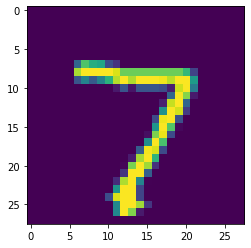

0.0


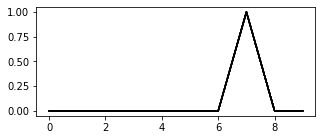

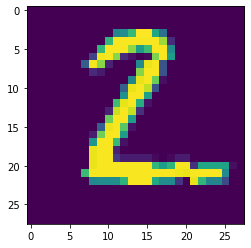

3.5527137e-15


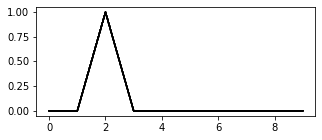

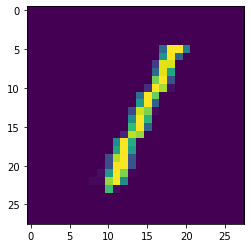

3.1974423e-14


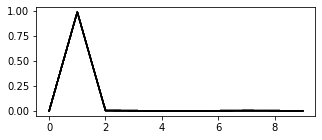

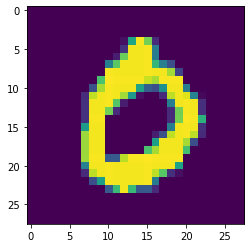

0.0


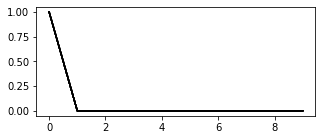

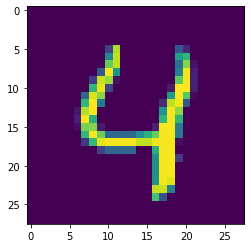

3.5527137e-15


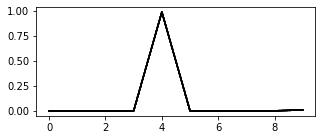

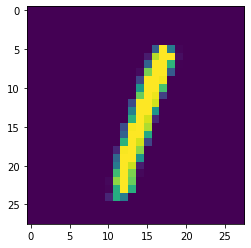

1.4210855e-14


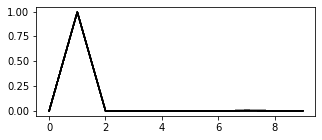

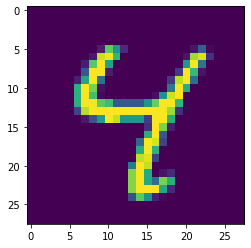

3.5527137e-15


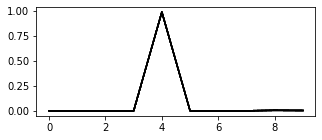

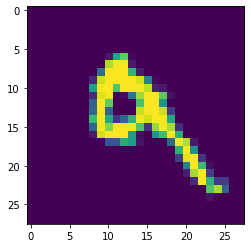

3.5527137e-15


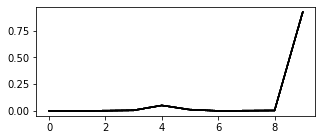

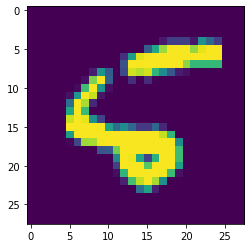

5.684342e-14


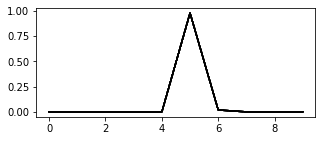

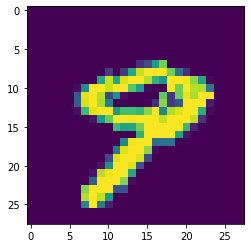

1.4210855e-14


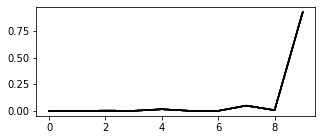

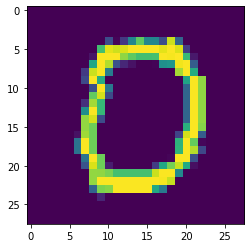

3.5527137e-15


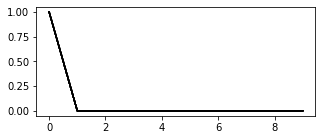

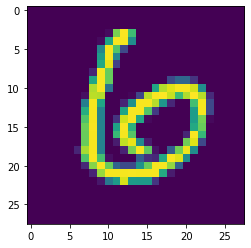

3.1974423e-14


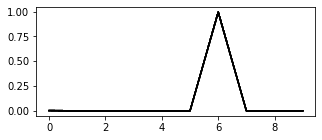

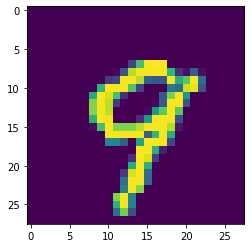

0.0


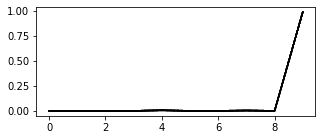

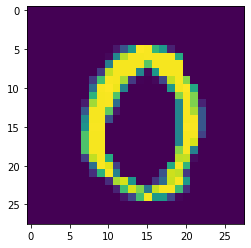

0.0


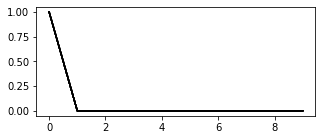

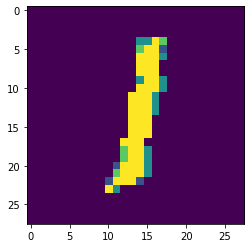

3.1974423e-14


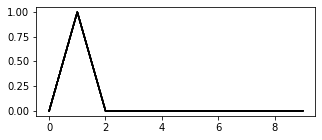

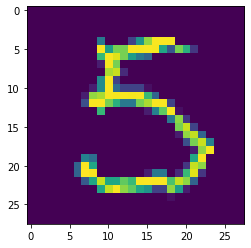

3.5527137e-15


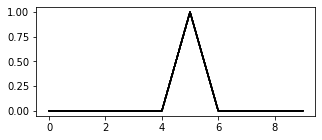

In [29]:
_x = x.data.cpu().numpy()

for i in range(16):
    plt.imshow(_x[i, 0])
    plt.show()
    
    _mean = np.mean(_ys[:, i], axis=0)
    _argmax = np.argmax(_mean)
    _variance = np.var(_ys[:, i, _argmax])
    print(_variance)
    
    np.argmax(_ys[:, i], axis=1)
    
    plt.figure(figsize=[5, 2])
    plt.plot(_ys[:, i].T, alpha=0.05, color='black')
    plt.show()
    